In [37]:
import numpy as np
from dataloader import SimulationData
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2

size = 128

train_transform = transforms.Compose([transforms.ToTensor(),
                                #transforms.CenterCrop((750,850)),
                                #transforms.Resize((1189,1273)),
                                #transforms.CenterCrop((1200,1000))
                                ])
val_transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((size,size)),
                                #transforms.Grayscale(num_output_channels = 1),
                                ])

repair_type = '001_hansson_pin_system'
data_dir = '/work3/dgro/Data/'
batch_size = 16

dataset = SimulationData(repair_type = repair_type, split = 'train', data_path = data_dir, transform = train_transform)

(926, 926)


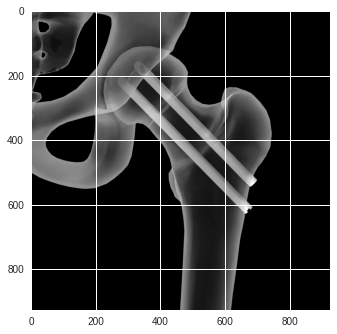

In [126]:
idx = 150

images, scores = dataset.__getitem__(idx)

im_frontal = (images.permute(1, 2, 3, 0)[0].numpy()*255).astype(np.uint8)
im_lateral= (images.permute(1, 2, 3, 0)[1].numpy()*255).astype(np.uint8)

gray1 = cv2.cvtColor(im_frontal, cv2.COLOR_BGR2GRAY)

plt.imshow(gray1)
print(gray1.shape)

(1189, 1273)


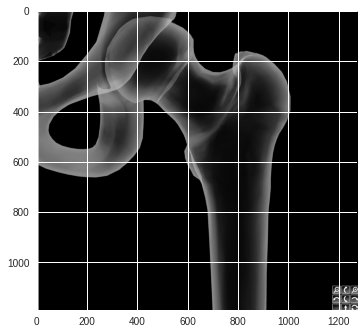

In [3]:
im_frontal_plain = cv2.imread('/work3/dgro/frontal.jpg') 
gray0 = cv2.cvtColor(im_frontal_plain, cv2.COLOR_BGR2GRAY)
plt.imshow(gray0)
print(gray0.shape)

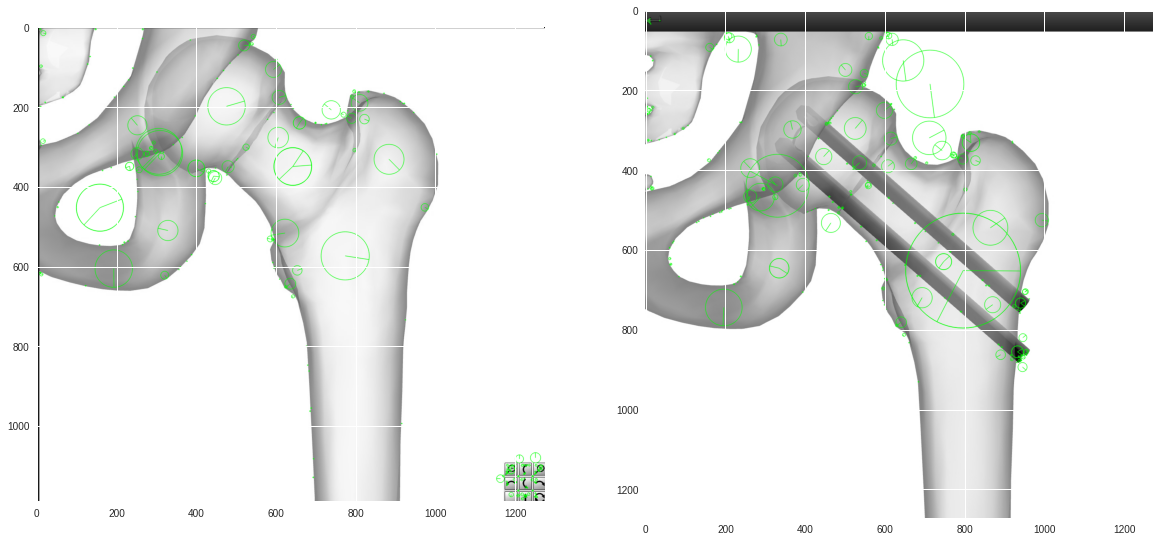

In [4]:
#keypoints
sift = cv2.SIFT_create()
keypoints_0, descriptors_0 = sift.detectAndCompute(im_frontal_plain,None)
keypoints_1, descriptors_1 = sift.detectAndCompute(im_frontal,None)

img_0 = cv2.drawKeypoints(gray0,keypoints_0, 0, (0, 255, 0),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_1 = cv2.drawKeypoints(gray1,keypoints_1, 0, (0, 255, 0),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(img_0)
plt.subplot(1,2,2)
plt.imshow(img_1)

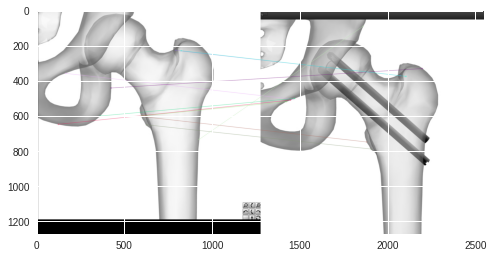

(<matplotlib.image.AxesImage at 0x7f1ab0b616d0>, None)

In [5]:
# create BFMatcher object
bf = cv2.BFMatcher(crossCheck=True)
# Match descriptors.
matches = bf.match(descriptors_0,descriptors_1)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Draw first 10 matches.
img3 = cv2.drawMatches(gray0,keypoints_0,gray1,keypoints_1,matches[:10],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

In [6]:
src_pts = np.float32([ keypoints_0[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
dst_pts = np.float32([ keypoints_1[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)

In [7]:
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
matchesMask = mask.ravel().tolist()

In [8]:
M

array([[ 9.82065615e-01, -1.08276869e-02,  1.75560065e+01],
       [-1.03882121e-02,  9.70731833e-01,  1.54669910e+02],
       [-6.48008967e-06, -1.10347902e-05,  1.00000000e+00]])

In [9]:
rows, cols = gray0.shape
img_out = np.zeros(gray0.shape)
test = cv2.warpPerspective(gray0,M,(rows,cols))#[:gray1.shape[0],:gray1.shape[1]]
if test.shape[1] > gray1.shape[1]:
    test = test[:,:gray1.shape[1]]
else:
    gray1 = gray1[:,:test.shape[1]]
if test.shape[0] > gray1.shape[0]:
    test = test[:gray1.shape[0],:]
else:
    gray1 = gray1[:test.shape[0],:]

print(test.shape)
print(gray1.shape)

(1272, 1189)
(1272, 1189)


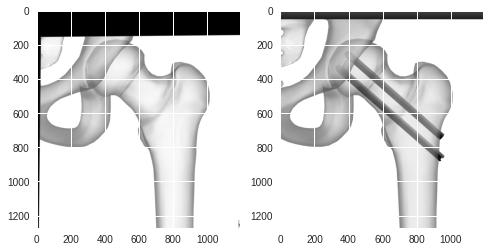

In [10]:
plt.subplot(1,2,1)
plt.imshow(test, cmap = 'gray')
plt.subplot(1,2,2)
plt.imshow(gray1, cmap = 'gray')

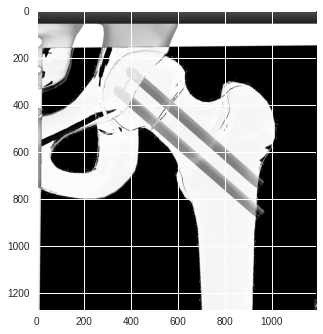

In [11]:
plt.imshow(gray1-test, cmap = 'gray')

In [12]:
im_test = (test-gray1)
for i in range(im_test.shape[0]):
    for ii in range(im_test.shape[1]):
        if im_test[i,ii] > 250:
            im_test[i,ii] = 0

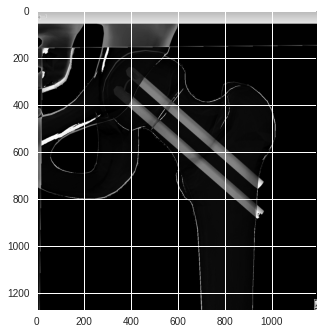

In [13]:
plt.imshow(im_test, cmap = 'gray')

In [14]:
for i in range(im_test.shape[0]):
    for ii in range(im_test.shape[1]):
        if im_test[i,ii] > 29:
            im_test[i,ii] = 1
        else:
            im_test[i,ii] = 0

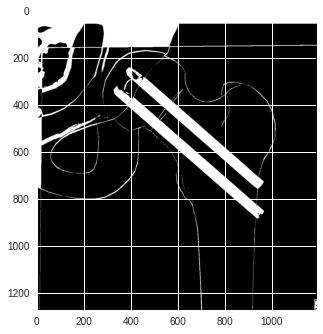

In [15]:
plt.imshow(im_test, cmap = 'gray')

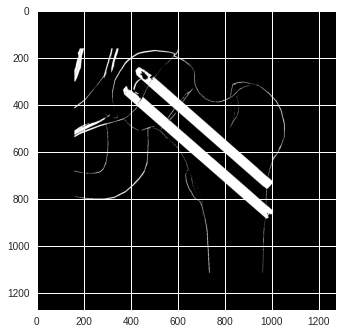

In [16]:
import torch
crop_size = int(np.floor((im_test.shape[0]*(3/4))))
pad = int((im_test.shape[0]-(crop_size-1))/2)
test = transforms.CenterCrop(crop_size)(torch.tensor(im_test))
test = transforms.Pad(pad)(test)
plt.imshow(test, cmap = 'gray')

In [122]:
type(test.numpy())

numpy.ndarray

In [127]:
# load plain image (without screws)
plain = cv2.imread('/work3/dgro/frontal.jpg')
plain = cv2.cvtColor(plain, cv2.COLOR_BGR2GRAY).astype(np.uint8)
# load image with bone mask
boneMask = cv2.imread('/work3/dgro/frontalBoneMask.png')
boneMask = cv2.cvtColor(boneMask, cv2.COLOR_BGR2GRAY).astype(np.uint8)
boneMask = np.where(boneMask>0, 1, 0).astype(np.uint8)
# load image with screws
image = gray1
# initialize SIFT
sift = cv2.SIFT_create()
# find keypoints and descriptors in each image
keypoints_plain, descriptors_plain = sift.detectAndCompute(plain,None)
keypoints_im, descriptors_im = sift.detectAndCompute(image,None)
# initialize brute force matcher
bf = cv2.BFMatcher(crossCheck=True)
# Match descriptors.
matches = bf.match(descriptors_plain,descriptors_im)
# find source and distance points
src_pts = np.float32([ keypoints_plain[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
dst_pts = np.float32([ keypoints_im[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
# Find Homography matrix
M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
# find shape of plain (without screws) image
rows, cols = plain.shape
an = cv2.warpPerspective(plain,M,(rows,cols))#[:image.shape[0],:image.shape[1]]
anBone = cv2.warpPerspective(boneMask,M,(rows,cols))
if an.shape[0] > image.shape[0]:
    an = an[:image.shape[0],:]
    anBone = anBone[:image.shape[0],:]
else:
    image = image[:an.shape[0],:]
if an.shape[1] > image.shape[1]:
    an = an[:,:image.shape[1]]
    anBone = anBone[:,:image.shape[1]]
else:
    image = image[:,:an.shape[1]]
assert an.shape == image.shape, "Annotation and image should be same size"
# subtract image to extract screws
an = (an-image)
# remove background
# an = (an-image)
# for i in range(an.shape[0]):
#     for ii in range(an.shape[1]):
#         if an[i,ii] > 250:
#             an[i,ii] = 0
# # convert to binary image
# for i in range(an.shape[0]):
#     for ii in range(an.shape[1]):
#         if an[i,ii] > 29:
#             an[i,ii] = 1
#         else:
#             an[i,ii] = 0
# threshold image and turn binary
#_,an = cv2.threshold(an,29,an.max(),cv2.THRESH_BINARY)
an = np.where(an>29, 1, 0).astype(np.uint8)
#an = np.clip(an, 0, 1)
# crop out background and pad to fit original shape
crop_size_x, crop_size_y = int(np.floor((an.shape[0]*(3/4)))), int(np.floor((an.shape[1]*(3/4))))
pad_x, pad_y = int((an.shape[0]-(crop_size_x-1))/2), int((an.shape[1]-(crop_size_y-1))/2)
an = transforms.CenterCrop((crop_size_x,crop_size_y))(torch.tensor(an))
an = (transforms.Pad((pad_x,pad_y))(an))

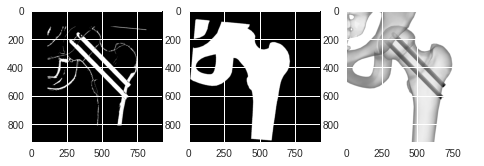

In [128]:
plt.subplot(1,3,1)
plt.imshow(an, cmap = 'gray')
plt.subplot(1,3,2)
plt.imshow(anBone, cmap = 'gray')
plt.subplot(1,3,3)
plt.imshow(image, cmap = 'gray')

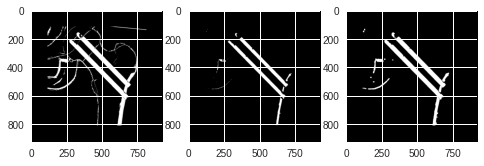

In [130]:
# Taking a matrix of size 5 as the kernel
kernel = np.ones((7,7), np.uint8)
 
# The first parameter is the original image,
# kernel is the matrix with which image is
# convolved and third parameter is the number
# of iterations, which will determine how much
# you want to erode/dilate a given image.
img_erosion = cv2.erode(an.numpy(), kernel, iterations=1)
#kernel = np.ones((5,5), np.uint8)
img_dilation = cv2.dilate(img_erosion, kernel, iterations=1)

plt.subplot(1,3,1)
plt.imshow(an, cmap = 'gray')
plt.subplot(1,3,2)
plt.imshow(img_erosion, cmap = 'gray')
plt.subplot(1,3,3)
plt.imshow(img_dilation, cmap = 'gray')

In [72]:
an

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

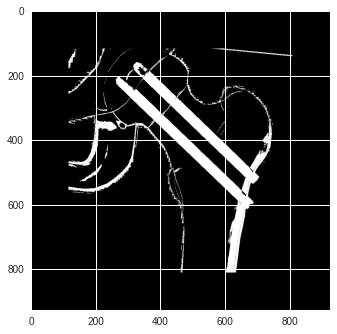

In [69]:

plt.imshow(test[0], cmap = 'gray')

In [29]:
boneMask.shape

(1125, 1204)

In [36]:
from PIL import Image

# Put threshold to make it binary
binarr = np.where(boneMask>0, 1, 0).astype(np.uint8)
# Covert numpy array back to image 
binarr.max()

1

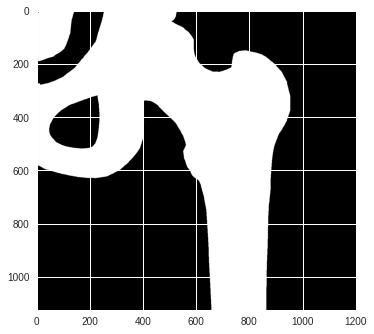